In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

## Steps:
### 1. Split the entire dataset into train and test
### 2. Store them in train.csv and test.csv respectively
### 3. Apply preprocessing on train.csv
### 4. Perform featurization and EDA on train.csv

# Load the data

In [2]:
dataset = pd.read_csv("Modified_SQL_Dataset.csv")
dataset.shape

(30919, 2)

In [3]:
dataset.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


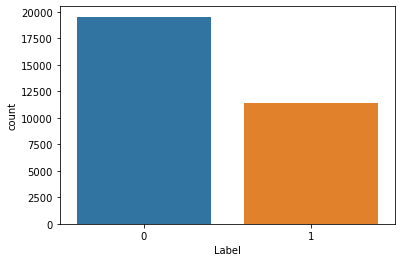

In [4]:
sns.countplot(x='Label',data=dataset)
plt.show()

## Observation:
### We can see that the two classes are imbalanced as we have far more points of class 0 than that of class 1, hence we will be using stratified splitting when we create train.csv and test.csv, so as to keep the proportion of class 0 and class 1 similar.

# Split the data into Train and Test

In [5]:
Y = dataset['Label']
X = dataset.drop('Label',axis = 1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33,stratify = Y)

In [6]:
print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)
print("Y_train shape :",Y_train.shape)
print("Y_test shape :",Y_test.shape)

X_train shape : (20715, 1)
X_test shape : (10204, 1)
Y_train shape : (20715,)
Y_test shape : (10204,)


In [7]:
X_train['label'] = Y_train
X_test['label'] = Y_test

<ipython-input-7-9f322bb95c54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['label'] = Y_train
<ipython-input-7-9f322bb95c54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['label'] = Y_test


In [8]:
print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)
print("Y_train shape :",Y_train.shape)
print("Y_test shape :",Y_test.shape)

X_train shape : (20715, 2)
X_test shape : (10204, 2)
Y_train shape : (20715,)
Y_test shape : (10204,)


In [9]:
X_train.head()

,Query,label
11352,elias pallares,0
25664,"SELECT duck, nearby+ ', ' + quiet+ ' ' + wi...",0
18391,40359,0
8464,1' in boolean mode ) and 6510 = ( sele...,1
28448,SELECT * FROM parallel WHERE felt = 'examine',0


In [10]:
X_train.to_csv("train.csv")

In [11]:
X_test.to_csv("test.csv")

## Read train.csv

In [12]:
data = pd.read_csv("train.csv")

In [13]:
data.shape

(20715, 3)

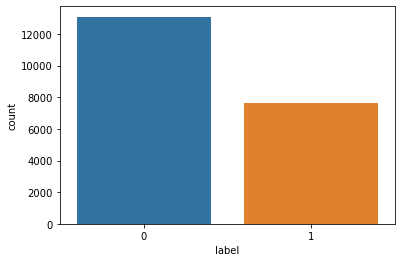

In [14]:
sns.countplot(x= 'label',data = data)
plt.show()

# Preprocessing data
### 1. converting all text to small letter
### 2. checking for duplicates
### 3. Not removing any special characters as they are an important aspect of a query(Domain Knowledge)

#### Convert To Lower Case

In [15]:
def convert_To_Lower_case(x):
    return x.lower()

In [16]:
#convert text to lower case
data['Query'] = data['Query'].apply(convert_To_Lower_case)

In [17]:
data.head()

,Unnamed: 0,Query,label
0,11352,elias pallares,0
1,25664,"select duck, nearby+ ', ' + quiet+ ' ' + wi...",0
2,18391,40359,0
3,8464,1' in boolean mode ) and 6510 = ( sele...,1
4,28448,select * from parallel where felt = 'examine',0


#### Check for duplicates

In [18]:
#checking for duplicates
boolean = data.duplicated(subset = ['Query','label'])

In [19]:
print(data[boolean])

       Unnamed: 0                                              Query  label
1535          525                                       union select      1
5975        19998       select replace ( "xyz fgh xyz", "x", "m" ) ;      0
7264        17913                                             #name?      0
10190         752                                       union select      1
11851       18233                                             #name?      0
13229       15635                                             #name?      0
13452       19333                                                28%      1
15074       19332                                                29%      1
15520       19961             select field ( "q", "s", "q", "l" ) ;       0
17243       13318                                             #name?      0
19842         723                           x' and email is null; --      1
20342         756                   x' and members.email is null; --      1
20353       

In [20]:
#dropping the duplicates
data.drop_duplicates(subset = ['Query','label'],inplace = True)

In [21]:
data.head()

,Unnamed: 0,Query,label
0,11352,elias pallares,0
1,25664,"select duck, nearby+ ', ' + quiet+ ' ' + wi...",0
2,18391,40359,0
3,8464,1' in boolean mode ) and 6510 = ( sele...,1
4,28448,select * from parallel where felt = 'examine',0


### Checking if the same query has different labels, if yes then del. them

In [22]:
boolean = data.duplicated(subset = ['Query'],keep = False)
print(data[boolean])

       Unnamed: 0   Query  label
2778        13532  #name?      0
4779        17499       1      0
18056        4244       1      1
20011         656  #name?      1


In [23]:
#dropping the duplicates
data.drop_duplicates(subset = ['Query'],keep = False,inplace = True)
boolean = data.duplicated(subset = ['Query'],keep = False)
print(data[boolean])

Empty DataFrame
Columns: [Unnamed: 0, Query, label]
Index: []


In [24]:
data.shape

(20698, 3)

# Feature Engineering:
### We will be using w2v or tf-idf to tokenize our train data, which generally ignore the punctuations and only consider alfabets and numbers. But these symbols carry importance in queries as they have special functionalities in a query 

In [25]:
sns.set(rc = {'figure.figsize':(15,8)})

#### 1. Single quotation mark(')

In [26]:
def number_of_single_quotations(x):
    list_single_quotes = re.findall("'",x)
    return len(list_single_quotes)

In [27]:
data['number_single_quotes'] = data.Query.apply(number_of_single_quotations) 

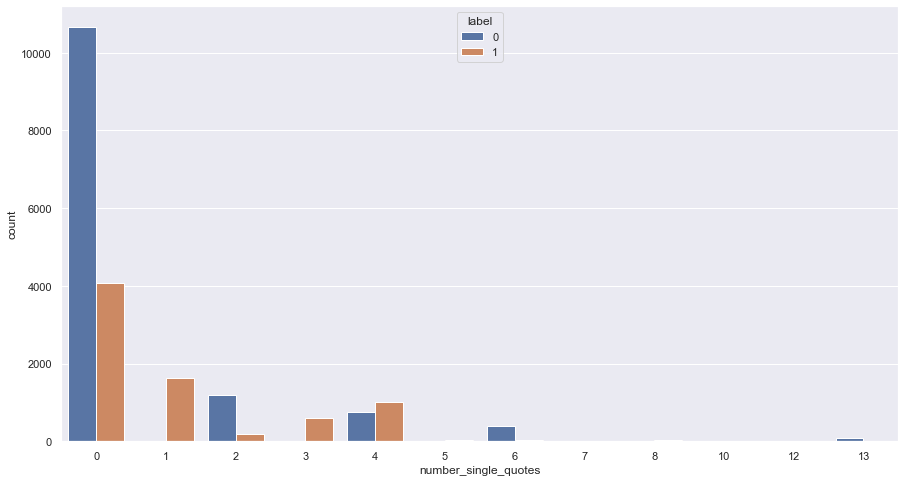

In [28]:
sns.countplot(x = 'number_single_quotes',hue = 'label',data = data)
plt.show()

Observations:

1. We see the that when the single quote appers 1 or 3 times ina query its genrally that the query is an sql injection and if the single quote comes 6 or 13 times its mostly not a sql injection.

#### 2. Double quotation mark(")

In [29]:
def number_of_double_quotations(x):
    list_double_quotes = re.findall("\"",x)
    return len(list_double_quotes)

In [30]:
data['number_double_quotes'] = data.Query.apply(number_of_double_quotations) 

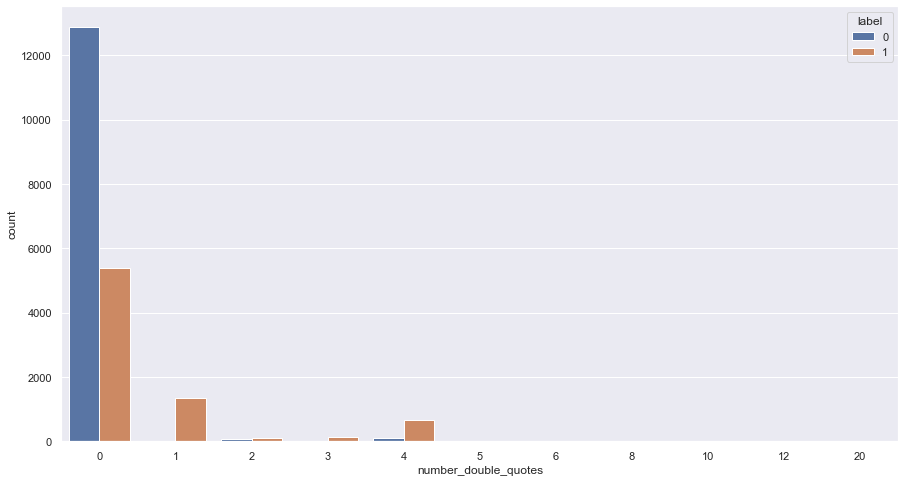

In [31]:
sns.countplot(x = 'number_double_quotes',hue = 'label',data = data)
plt.show()

Observations:

1. We see the that when the double quote appers 1 or 3 times ina a query its genrally that the query is an sql injection.

### 3. Hash(#)

In [32]:
def number_of_hash(x):
    list_hash = re.findall("#",x)
    return len(list_hash)

In [33]:
data['number_hash'] = data.Query.apply(number_of_hash) 

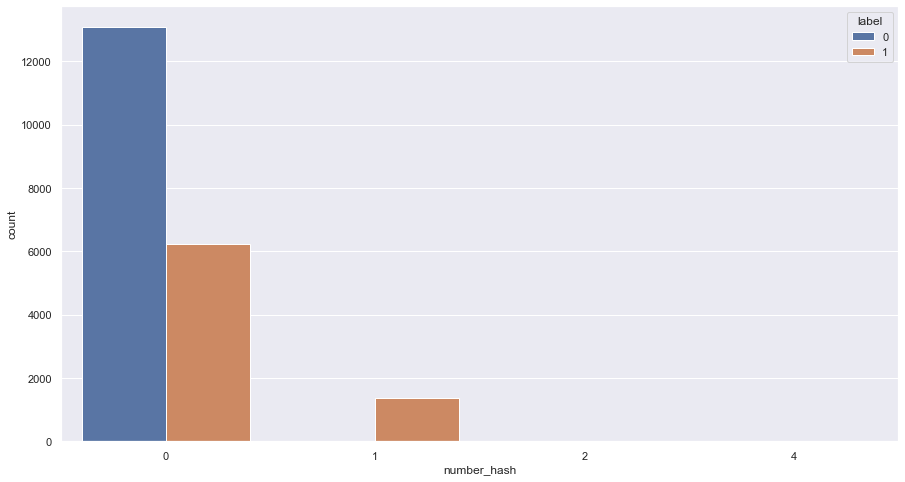

In [34]:
sns.countplot(x = 'number_hash',hue = 'label',data = data)
plt.show()

Observations:

1. We see the that when the hash appers 1 time in a query its genrally that the query is an sql injection.

### 4. Dollar($)

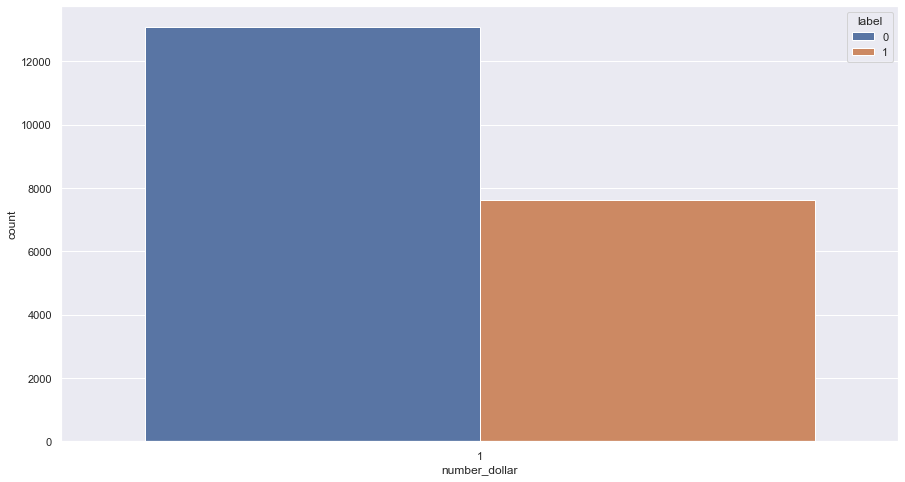

In [35]:
def number_of_dollar(x):
    list_dollar = re.findall("$",x)
    return len(list_dollar)
data['number_dollar'] = data.Query.apply(number_of_dollar)
sns.countplot(x = 'number_dollar',hue = 'label',data = data)
plt.show()

Observations:
1. We see that dollar only appers once in each of the queries and it very difficult to make any assumption.

### 5.Paranthesis( () )

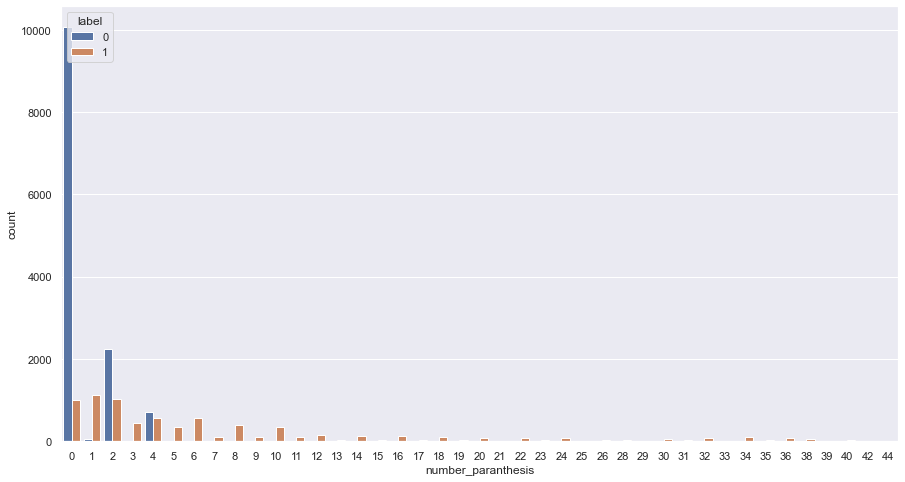

In [36]:
def number_of_paranthesis(x):
    list_paranthesis = re.findall("\(|\)",x)
    return len(list_paranthesis)
data['number_paranthesis'] = data.Query.apply(number_of_paranthesis)
sns.countplot(x = 'number_paranthesis',hue = 'label',data = data)
plt.show()

In [37]:
count_for_zero_sqli = len(data[(data.number_paranthesis == 0) & (data.label == 1)])
total = len(data[(data.number_paranthesis == 0)])
print(count_for_zero_sqli/total)

0.08965080513841144


In [38]:
count_for_zero_non_sqli = len(data[(data.number_paranthesis == 0) & (data.label == 0)])
print(count_for_zero_non_sqli/total)

0.9103491948615886


Observations:
1. We see that if either of the paranthesis occur 3 times or 5 or more times then it is generally an sql injection.
2. We also observe that only 91% of the the times if there is no paranthesis then its not a sqli

### 6.Square Brackets ([])

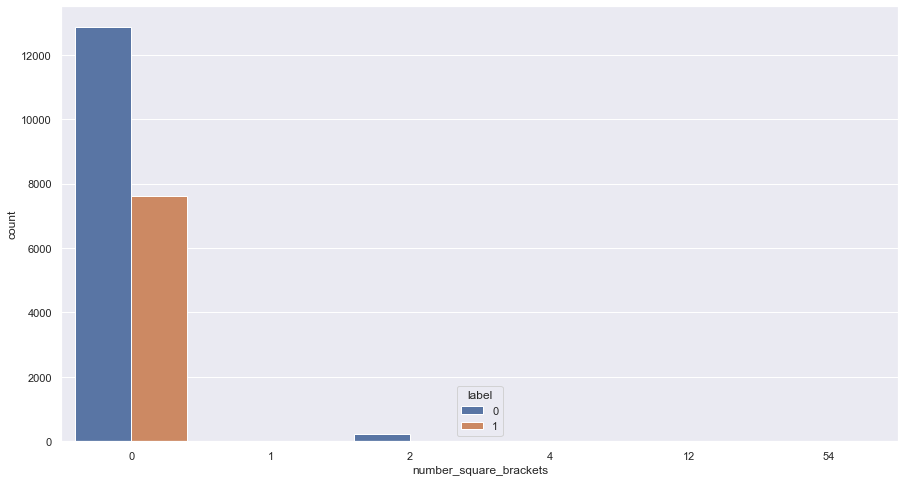

In [39]:
def number_of_square_brackets(x):
    list_square_brackets = re.findall("\[|\]",x)
    return len(list_square_brackets)
data['number_square_brackets'] = data.Query.apply(number_of_square_brackets)
sns.countplot(x = 'number_square_brackets',hue = 'label',data = data)
plt.show()

Observations:
1. From the above graph we notice that [] brackets hardly seen in the queries and if we see some then it is mostly not a sql injection 

### 7. @ symbol

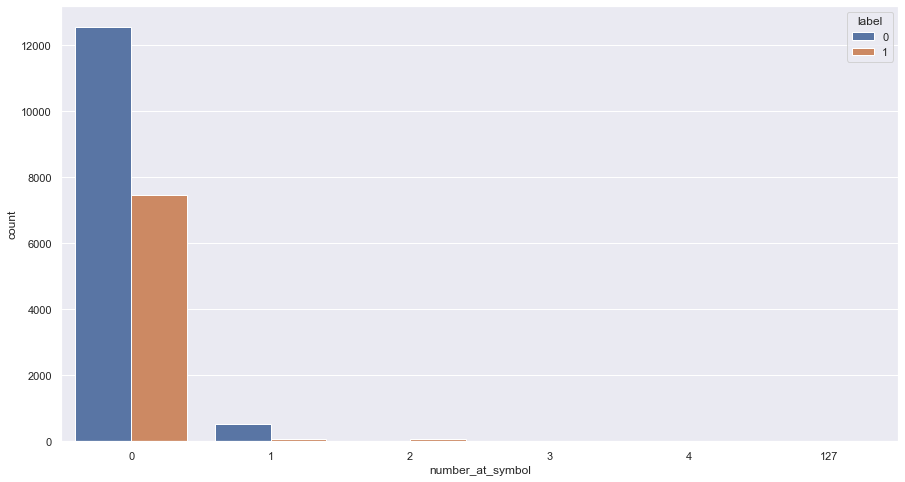

In [40]:
def number_of_at_symbol(x):
    list_at_symbol = re.findall("@",x)
    return len(list_at_symbol)
data['number_at_symbol'] = data.Query.apply(number_of_at_symbol)
sns.countplot(x = 'number_at_symbol',hue = 'label',data = data)
plt.show()

Observations:
1. We see that there is overlap for @ symbol and we also see that some points have more than 120 @ occurences, which could be outliers, after removing them we will the plot a box plot to see if we find any overlap

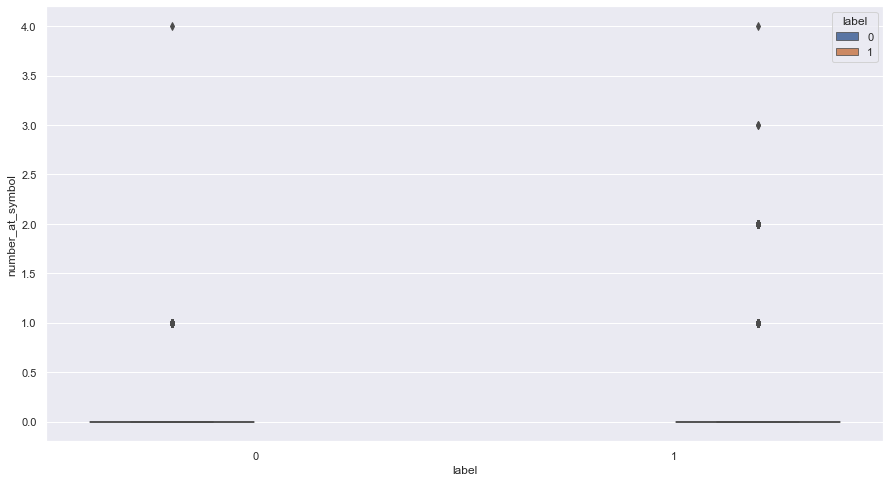

In [114]:
data1 = data[data['number_at_symbol']<120]
sns.boxplot(y = 'number_at_symbol',x = 'label',hue = 'label',data = data1)
plt.show()

Observations:
1. We see from the above graph that there is an overlap for @ symbol and hence we cannot make any conclusions from it. 

### 8.Colon(:)

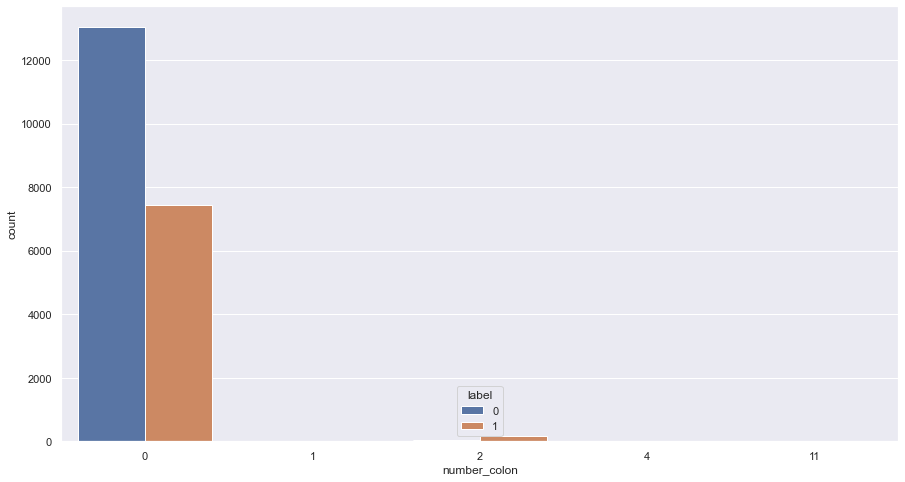

In [41]:
def number_of_colon(x):
    list_colon = re.findall(":",x)
    return len(list_colon)
data['number_colon'] = data.Query.apply(number_of_colon)
sns.countplot(x = 'number_colon',hue = 'label',data = data)
plt.show()

Observations:
1. We see from the above graph that there is an overlap for : symbol and hence we cannot make any conclusions from it.
2. We may not use number of : as a feature 

### 9.Semicolon(;)

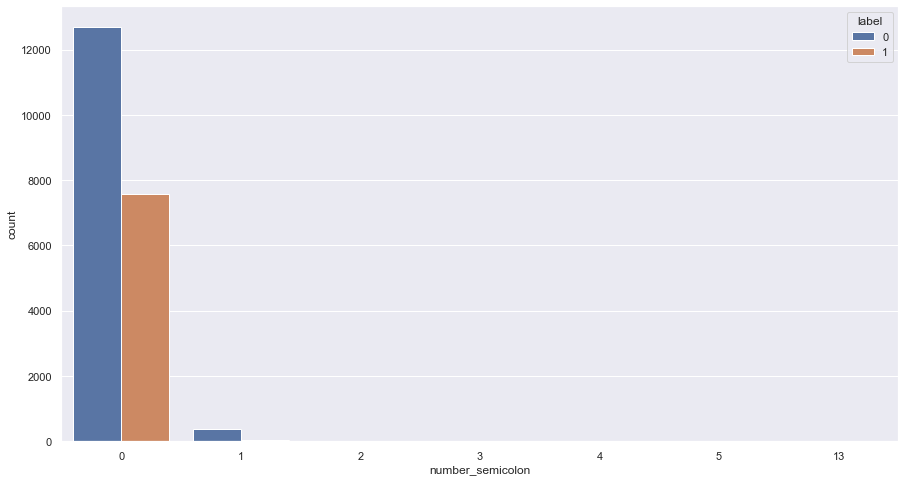

In [42]:
def number_of_semicolon(x):
    list_semicolon = re.findall(";",x)
    return len(list_semicolon)
data['number_semicolon'] = data.Query.apply(number_of_semicolon)
sns.countplot(x = 'number_semicolon',hue = 'label',data = data)
plt.show()

Observations:
1. We see from the above graph that ; hardly occurs in any query and if we see a semicolon it is usually not an sql injection.
2. We can use ; as a feature

### 10. equals to (=)

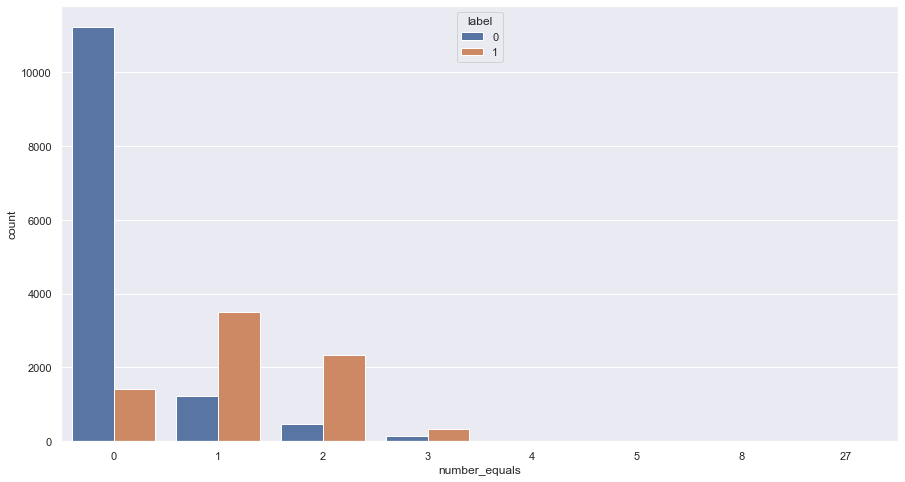

In [43]:
def number_of_equals(x):
    list_equals = re.findall("=",x)
    return len(list_equals)
data['number_equals'] = data.Query.apply(number_of_equals)
sns.countplot(x = 'number_equals',hue = 'label',data = data)
plt.show()

Observation:
1.  We see from the above graph that there is an overlap for = symbol and hence we cannot make any conclusions from it.

### 11. angular brackets(<>)

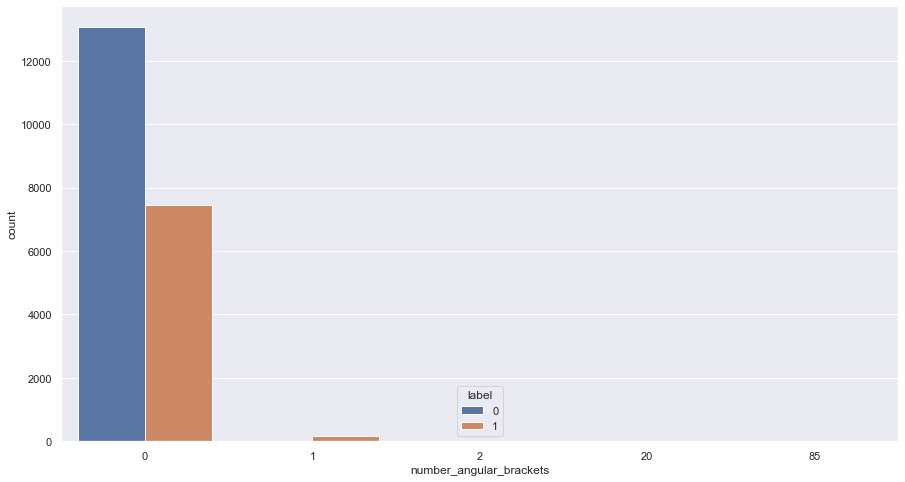

In [44]:
def number_of_angular_brackets(x):
    list_angular_brackets = re.findall("<|>",x)
    return len(list_angular_brackets)
data['number_angular_brackets'] = data.Query.apply(number_of_angular_brackets)
sns.countplot(x = 'number_angular_brackets',hue = 'label',data = data)
plt.show()

Observation:
1. We see that angular brackets hardly occur in any query but a handful of queries which have angular brackets are sql injection but since the quantity is so small we cannot say anything conclusively.

### 12.Question Mark(?)

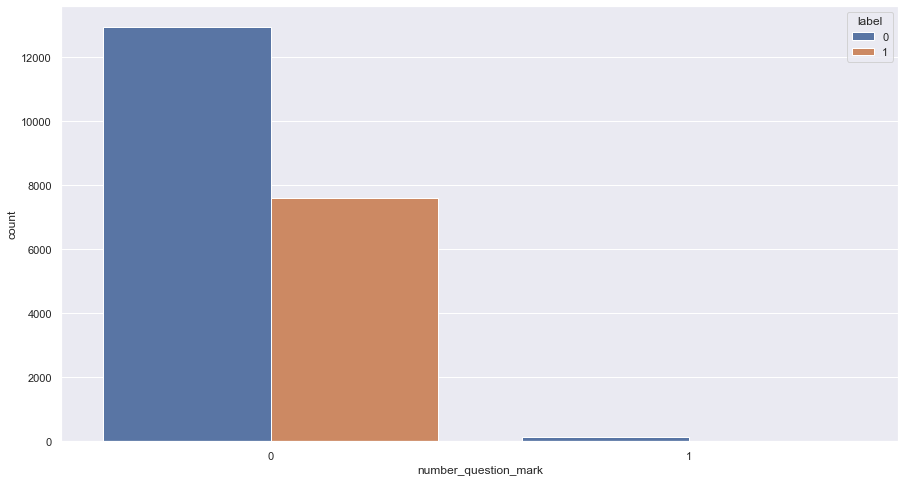

In [45]:
def number_of_question_mark(x):
    list_question_mark = re.findall("\?",x)
    return len(list_question_mark)
data['number_question_mark'] = data.Query.apply(number_of_question_mark)
sns.countplot(x = 'number_question_mark',hue = 'label',data = data)
plt.show()

Observation:
1. We see that question mark hardly occur in any query but a handful of queries which have question mark are not sql injection but since the quantity is so small we cannot say anything conclusively.

### 13. Power(^)

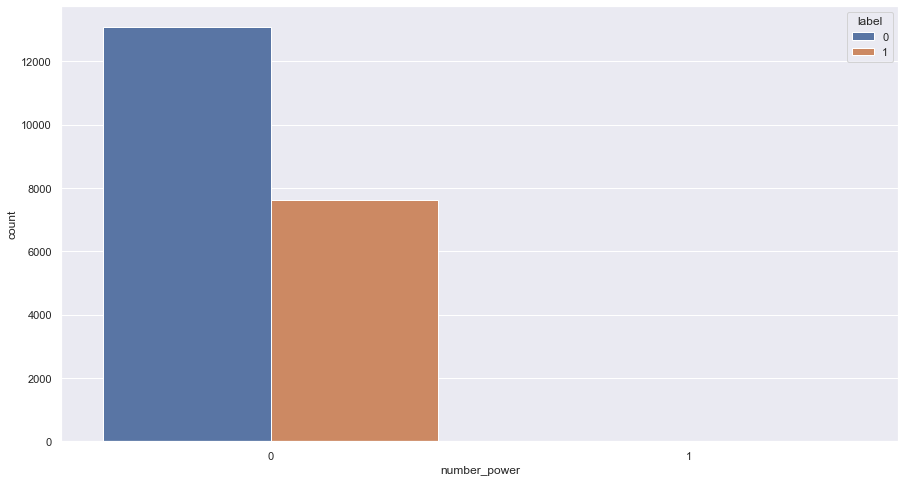

In [46]:
def number_of_power(x):
    list_power = re.findall("\^",x)
    return len(list_power)
data['number_power'] = data.Query.apply(number_of_power)
sns.countplot(x = 'number_power',hue = 'label',data = data)
plt.show()

Observation:
1. We see that angular brackets hardly occur in any query and can be ignored.

### 14. Underscore(_)

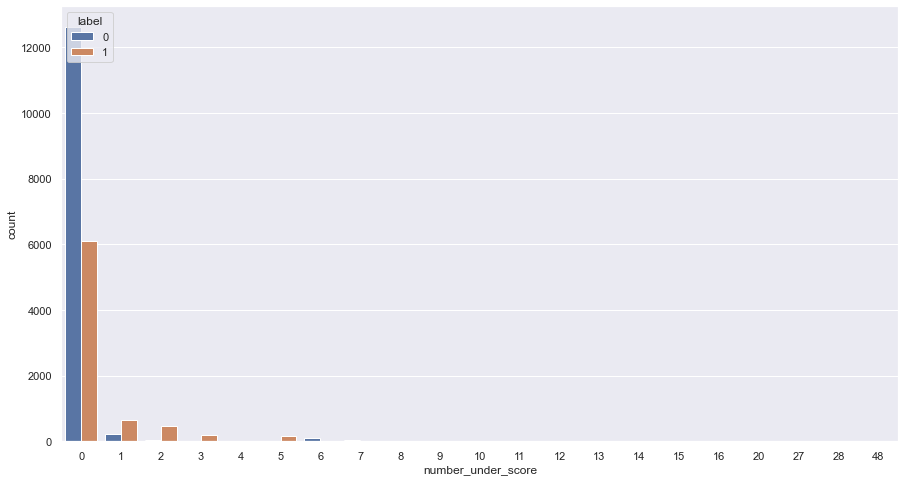

In [119]:
def number_of_under_score(x):
    list_under_score = re.findall("\_",x)
    return len(list_under_score)
data['number_under_score'] = data.Query.apply(number_of_under_score)
sns.countplot(x = 'number_under_score',hue = 'label',data = data)
plt.show()

Observation:

1.We see that when underscore occurs more than once it is generally a sql injection

### 15. curly brackets ({})

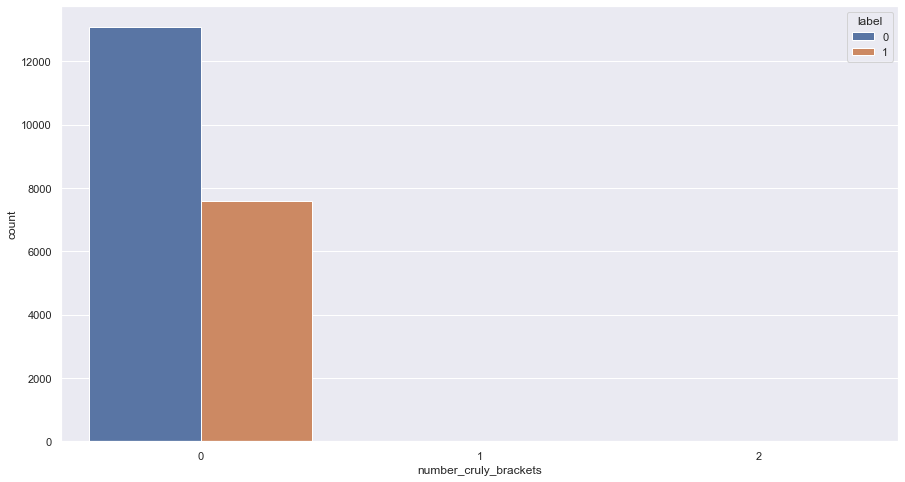

In [48]:
def number_of_cruly_brackets(x):
    list_cruly_brackets = re.findall("{|}",x)
    return len(list_cruly_brackets)
data['number_cruly_brackets'] = data.Query.apply(number_of_cruly_brackets)
sns.countplot(x = 'number_cruly_brackets',hue = 'label',data = data)
plt.show()

Observation:
1. We see that angular brackets hardly occur in any query and can be ignored.

### 16. Arthematic operators( +,-,*,/)

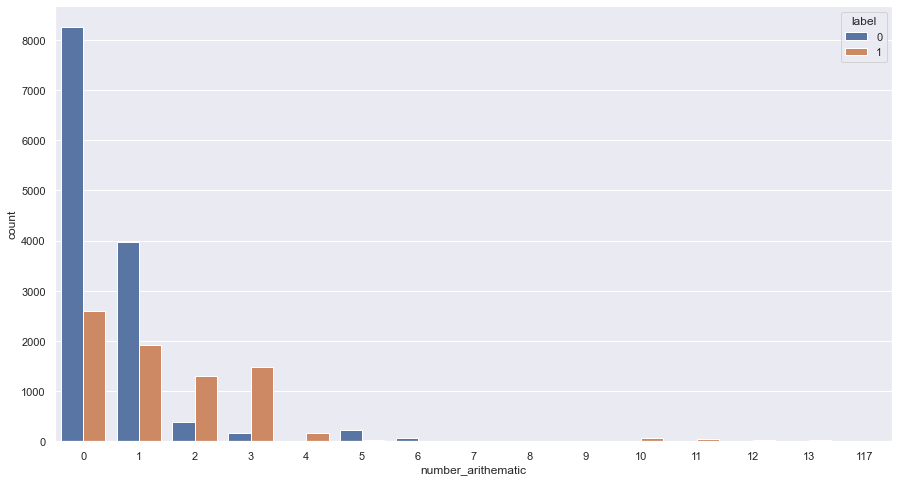

In [49]:
def number_of_arithematic(x):
    list_arithematic = re.findall("\+|-|[^\/]\*|\/[^\*]",x)
    return len(list_arithematic)
data['number_arithematic'] = data.Query.apply(number_of_arithematic)
sns.countplot(x = 'number_arithematic',hue = 'label',data = data)
plt.show()

Observation:
1. We see overlap of the arithmetic feature for two classes and we cannot say anything conclusively.

### 17.comma(,)

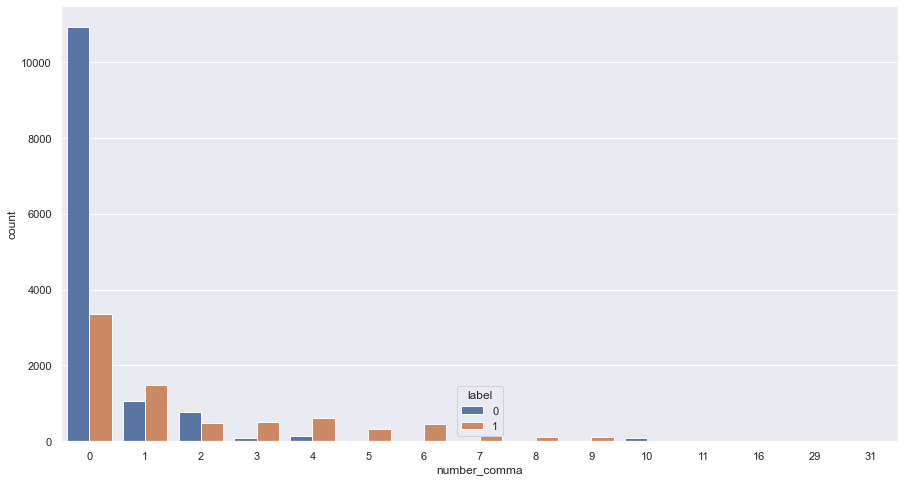

In [50]:
def number_of_comma(x):
    list_comma = re.findall(",",x)
    return len(list_comma)
data['number_comma'] = data.Query.apply(number_of_comma)
sns.countplot(x = 'number_comma',hue = 'label',data = data)
plt.show()

Observations:
1. We see that if comma appers 5 or more times in a sql query then it is probably a sql injection.

### 18. dot (.)

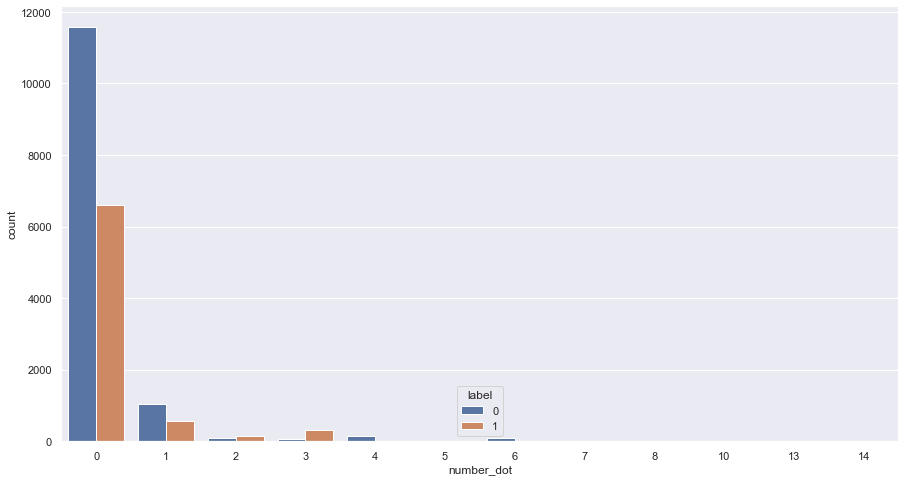

In [51]:
def number_of_dot(x):
    list_dot = re.findall("\.",x)
    return len(list_dot)
data['number_dot'] = data.Query.apply(number_of_dot)
sns.countplot(x = 'number_dot',hue = 'label',data = data)
plt.show()

Observation:
1. We see overlap of the dot feature for two classes and we cannot say anything conclusively

###  19.Single-Line comment (--)

In [52]:
def number_of_single_comment(x):
    list_single_comment = re.findall("(--)",x)
    return len(list_single_comment)

In [53]:
data['number_single_comment'] = data.Query.apply(number_of_single_comment) 

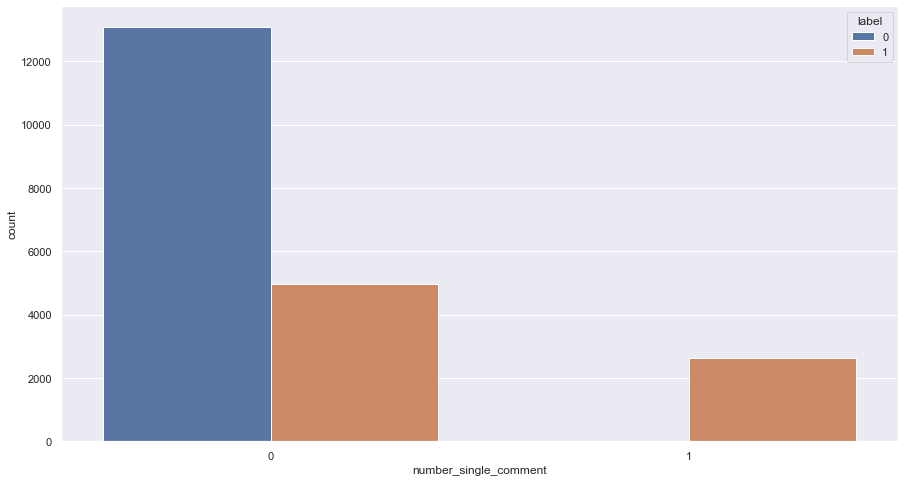

In [54]:
sns.countplot(x = 'number_single_comment',hue = 'label',data = data)
plt.show()

Observations:
1. We see that if there is a single line comment present in the query then is it a sql injection

### 20. Multi-line comment(/*)

In [55]:
def number_of_multiline_comment(x):
    list_multiline_comment = re.findall("(\/\*)",x)
    return len(list_multiline_comment)

In [56]:
data['number_of_multiline_comment'] = data.Query.apply(number_of_multiline_comment) 

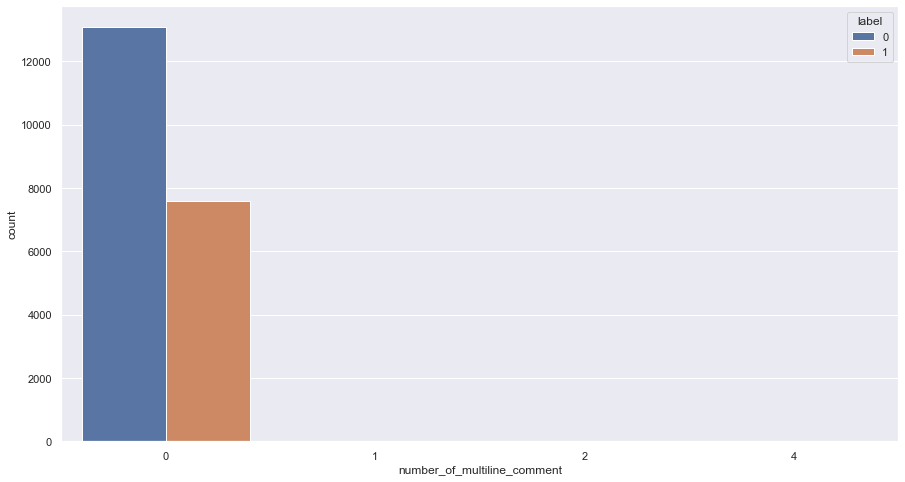

In [57]:
sns.countplot(x = 'number_of_multiline_comment',hue = 'label',data = data)
plt.show()

Observation:
1. We see multiline comments harly occur in any query and hence we may not use this feature.

### 21. whitespace character( )

In [58]:
def number_of_white_space(x):
    list_white_space = re.findall("\s+",x)
    return len(list_white_space)

In [59]:
data['number_white_space'] = data.Query.apply(number_of_white_space) 

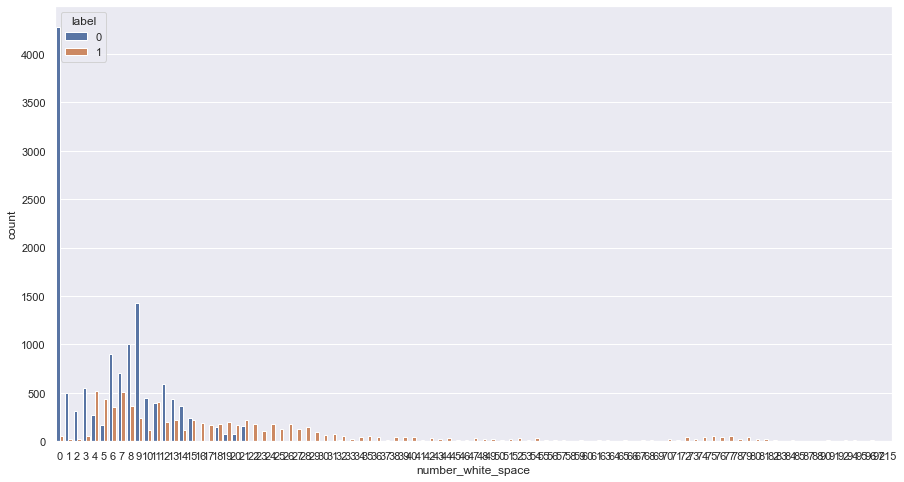

In [60]:
sns.countplot(x = 'number_white_space',hue = 'label',data = data)
plt.show()

Observations:
1. We see that higher fequencies of white spaces are generally found in sql injection.

### 22. Percentage(%)

In [61]:
def number_of_percentage(x):
    list_percentage = re.findall("%",x)
    return len(list_percentage)

In [62]:
data['number_percentage'] = data.Query.apply(number_of_percentage) 

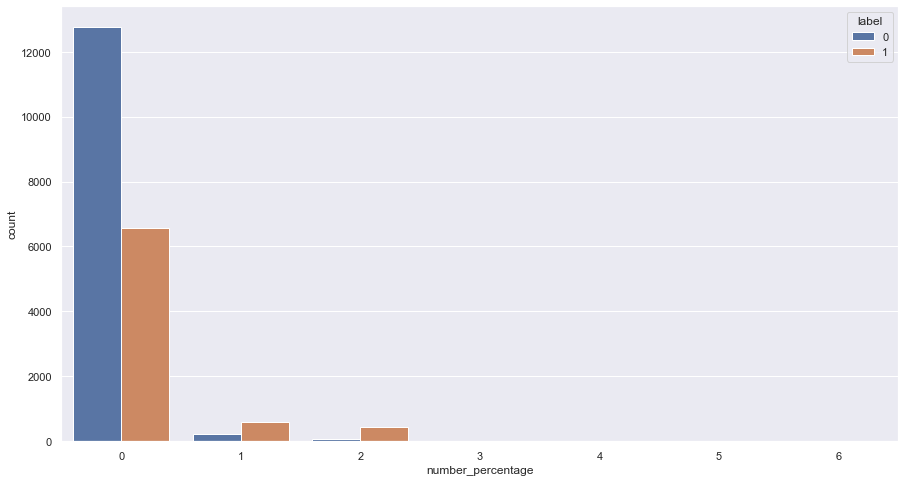

In [63]:
sns.countplot(x = 'number_percentage',hue = 'label',data = data)
plt.show()

Observations:
1. As we overlap for the fequencies of percentage sign hence we cannot say anything conclusively.

### 23.Logica operators( and ,or, not, xor, &&, ||, !)

In [64]:
def number_of_logical_operators(x):
    list_logical_operators = re.findall("\snot\s|\sand\s|\sor\s|\sxor\s|&&|\|\||!",x)
    return len(list_logical_operators)

In [65]:
data['number_logical_operators'] = data.Query.apply(number_of_logical_operators) 

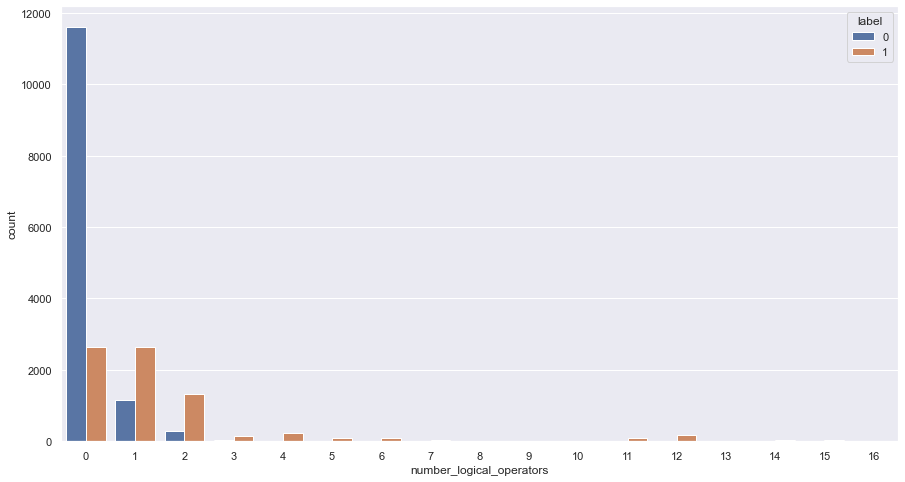

In [66]:
sns.countplot(x = 'number_logical_operators',hue = 'label',data = data)
plt.show()

Observations:
1. We see that if the logical operators occur 3 times or more the queries are generally sql injection

### 24.Punctuations

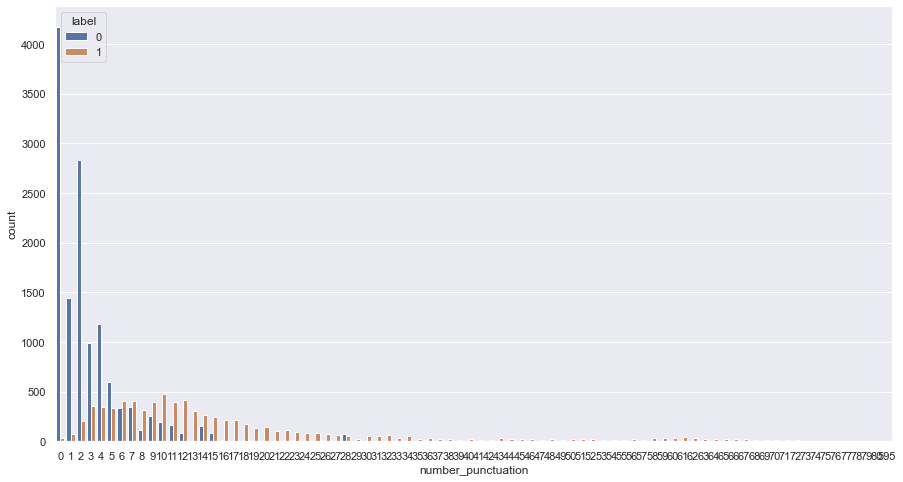

In [108]:
def number_of_punctuation(x):
    list_punctuation = re.findall("[!\"#$%&\'()*+,-.\/:;<=>?@[\\]^_`{|}~]",x)
    return len(list_punctuation)
data['number_punctuation'] = data.Query.apply(number_of_punctuation)
sns.countplot(x = 'number_punctuation',hue = 'label',data = data)
plt.show()

Observations:
1. We see that as the number of punctuations increases, the chances of it being a sql-injection also increases.
2. To further analyse we will plot a box-plot

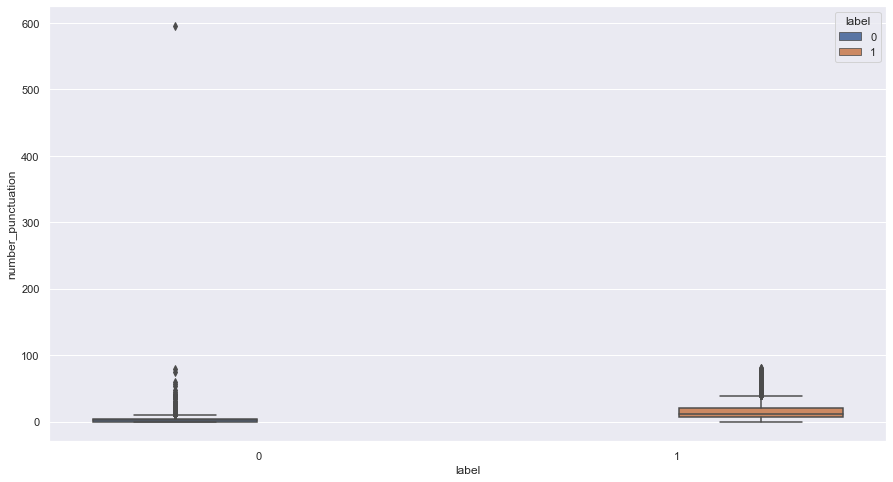

In [110]:
sns.boxplot(y = 'number_punctuation',x = 'label',hue = 'label',data = data)
plt.show()

Observations:
1. We observe that due to some oulier having a frequency more than 500 we cannot visualise the plot properly and make observatons and hence we will remove those points and then again analyse the box plot

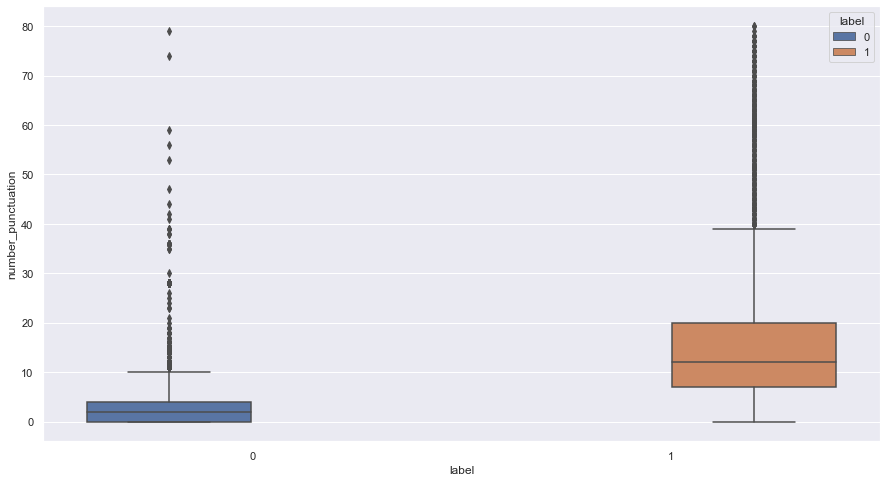

In [111]:
data1 = data[data['number_digits']<600]
sns.boxplot(y = 'number_punctuation',x = 'label',hue = 'label',data = data1)
plt.show()

Observations:
1. After reading the above graph we can see that the boxes for the two classes do not overlap completely and hance we can say that as the numbe of ounctuations increases it chances of being a sql injection also increases.

### 25.Hexadecimal numbers

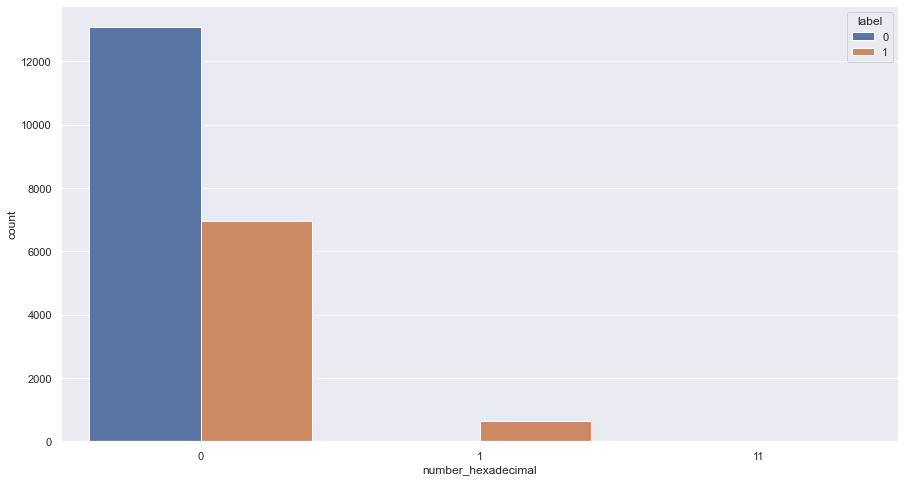

In [68]:
def number_of_hexadecimal(x):
    list_hexadecimal = re.findall("0[xX][0-9a-fA-F]+\s",x)
    return len(list_hexadecimal)
data['number_hexadecimal'] = data.Query.apply(number_of_hexadecimal)
sns.countplot(x = 'number_hexadecimal',hue = 'label',data = data)
plt.show()

Observations:
1. We see that when hexadecimal numbers occur in a query its generally a sql injection

### 26.Null

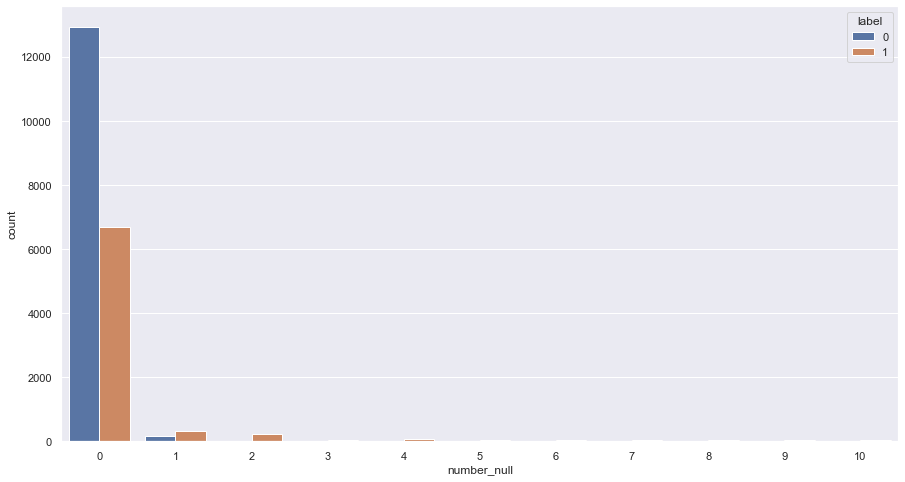

In [73]:
def number_of_null(x):
    list_null = re.findall("null",x)
    return len(list_null)
data['number_null'] = data.Query.apply(number_of_null)
sns.countplot(x = 'number_null',hue = 'label',data = data)
plt.show()

Observations:
1. We notice that null values sheldom occur in a query but if we have more than 1 null value its observed to be a sql-injection

### 27. Digits

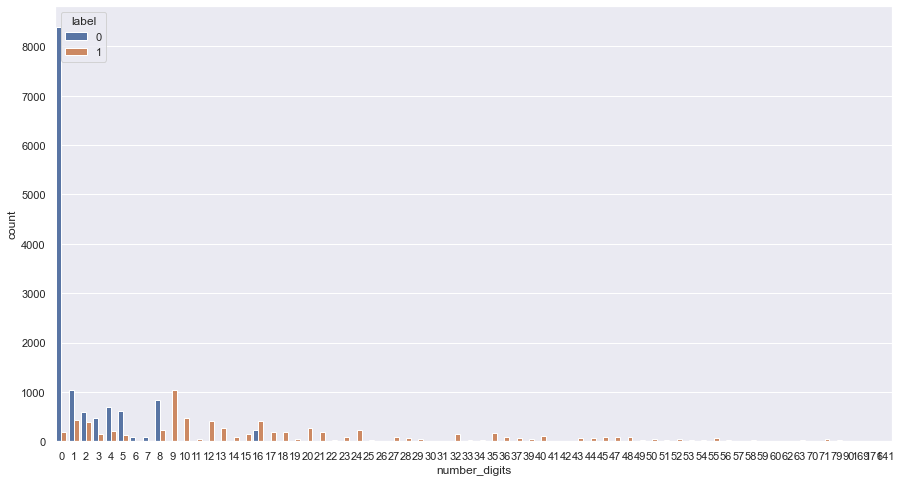

In [74]:
def number_of_digits(x):
    list_digits = re.findall("[0-9]",x)
    return len(list_digits)
data['number_digits'] = data.Query.apply(number_of_digits)
sns.countplot(x = 'number_digits',hue = 'label',data = data)
plt.show()

Observation:
1. we see that as the number of digits increase in a query the query tends to be a sql injection. Since we cannot see the graph clearly, to confirm our observation we will also plot a box-plot 

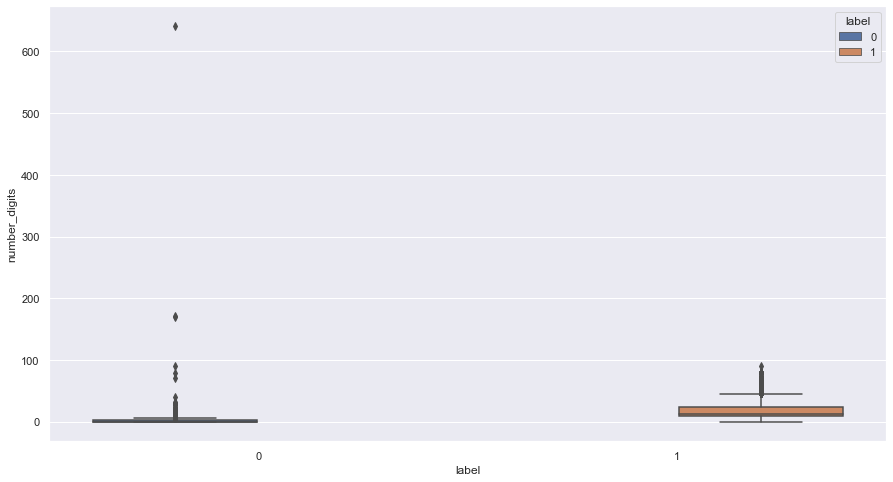

In [84]:
sns.boxplot(y = 'number_digits',x = 'label',hue = 'label',data = data)
plt.show()

Observation:
1. Due to a few outliers we cannot visualise the box-plot properly, hence we will remove the outlier ans then again create a box-plot

In [85]:
data1 = data[data['number_digits']<600]

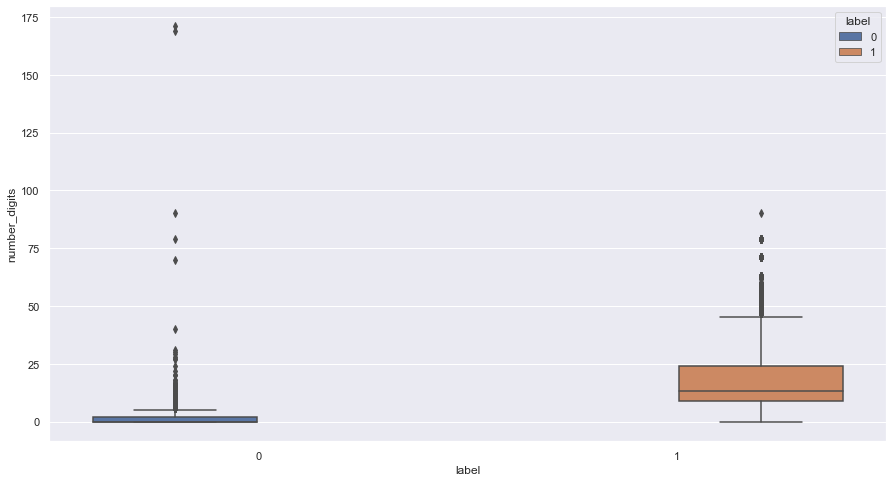

In [87]:
sns.boxplot(y = 'number_digits',x = 'label',hue = 'label',data = data1)
plt.show()

Observation:
1. The box plot confirms our hypothesis as we do not see much overlap between the two classes, hence as the number of digits increase the query is shown to be a sql-injection

### 28.Alfabets

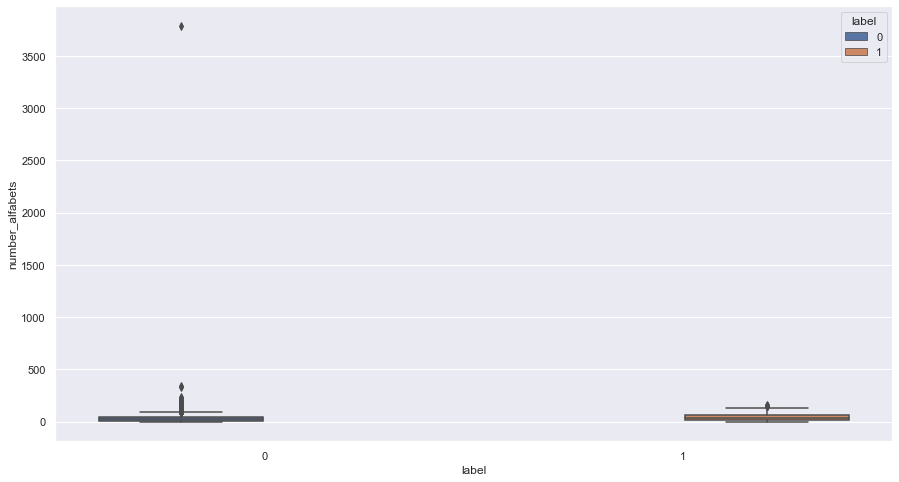

In [80]:
def number_of_alfabets(x):
    list_alfabets = re.findall("[a-zA-Z]",x)
    return len(list_alfabets)
data['number_alfabets'] = data.Query.apply(number_of_alfabets)
sns.boxplot(y = 'number_alfabets',x = 'label',hue = 'label',data = data)
plt.show()

Observation:
1. Due to a few outliers we cannot visualise the box-plot properly, hence we will remove the outlier ans then again create a box-plot

In [82]:
data1 = data[data['number_alfabets']<3500]

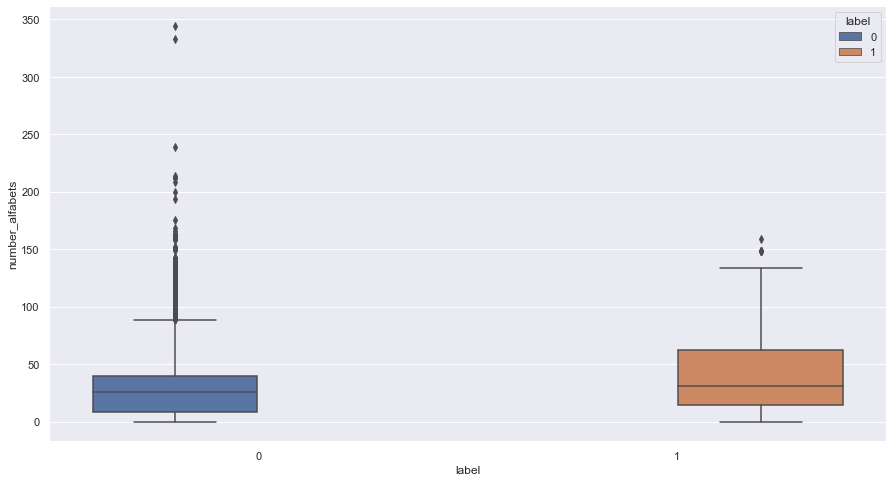

In [83]:
def number_of_alfabets(x):
    list_alfabets = re.findall("[a-zA-Z]",x)
    return len(list_alfabets)
data['number_alfabets'] = data.Query.apply(number_of_alfabets)
sns.boxplot(y = 'number_alfabets',x = 'label',hue = 'label',data = data1)
plt.show()

Observation:
1. From box plot we do not see much overlap between the two classes, hence as the number of alfabets increase the query is shown to be a sql-injection

### Analysis the word cloud of queries for each class

In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [88]:
comment_words_class_0 = ""
comment_words_class_1 = ""
for index in range(0,data.shape[0]):
    val = str(data.Query.iloc[index])
    tokens = val.split()
    if(data.label.iloc[index] == 0):
        comment_words_class_0 += " ".join(tokens)+ " "
    else:
        comment_words_class_1 += " ".join(tokens)+ " "

In [89]:
 wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_class_1)

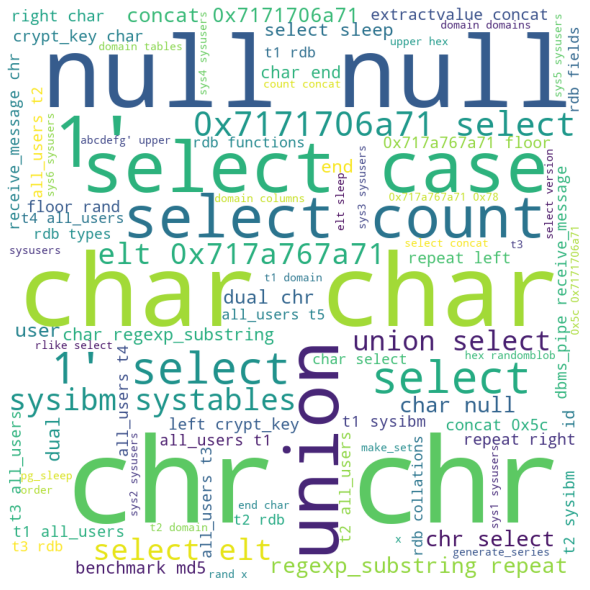

In [90]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [91]:
 wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_class_0)

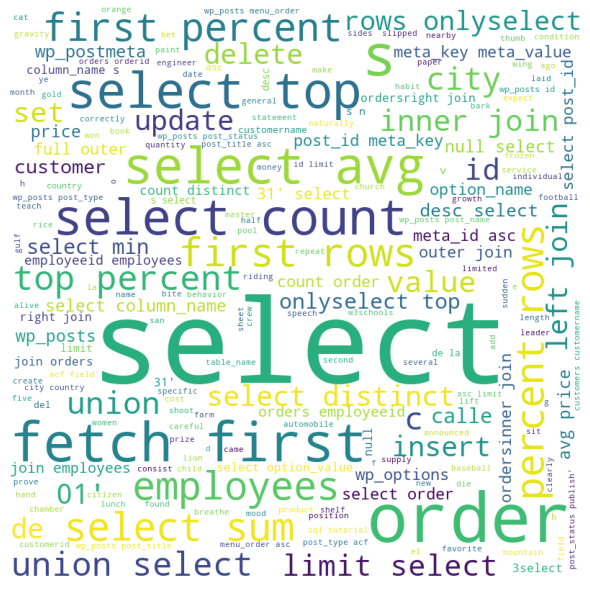

In [92]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Observations:
1. We see that some words occurs more in sql-injcetion like union,hexadecimal number,null,etc ,whereas the non sql-injection queries have common query words like select,coung,avg,etc.
2. So from the first observation we can say that we can use Bag of words or tfidf to featurize or query and then apply model to the same.

## Final observations:
### We will use  the frequency of the symbols mentioned below as features while modelling
#### 1. We will use all the feature except, multiline-comment, angular brackets and power as they hardly appear in any query.
#### 2. We will use Bag of words and tfidf to tokenize the query data to create more features.